# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

воспользуемся данными из файла geo.xlsx

In [3]:
votes = pd.read_excel('geo.xlsx', index_col=0)

In [4]:
votes.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


в данных очень много строк-дубликатов. Для разделения исходоный выборки на кластеры используем только уникальные значения по голосованию

In [97]:
v1 = votes.drop_duplicates(['x','y', 'comment_class'])

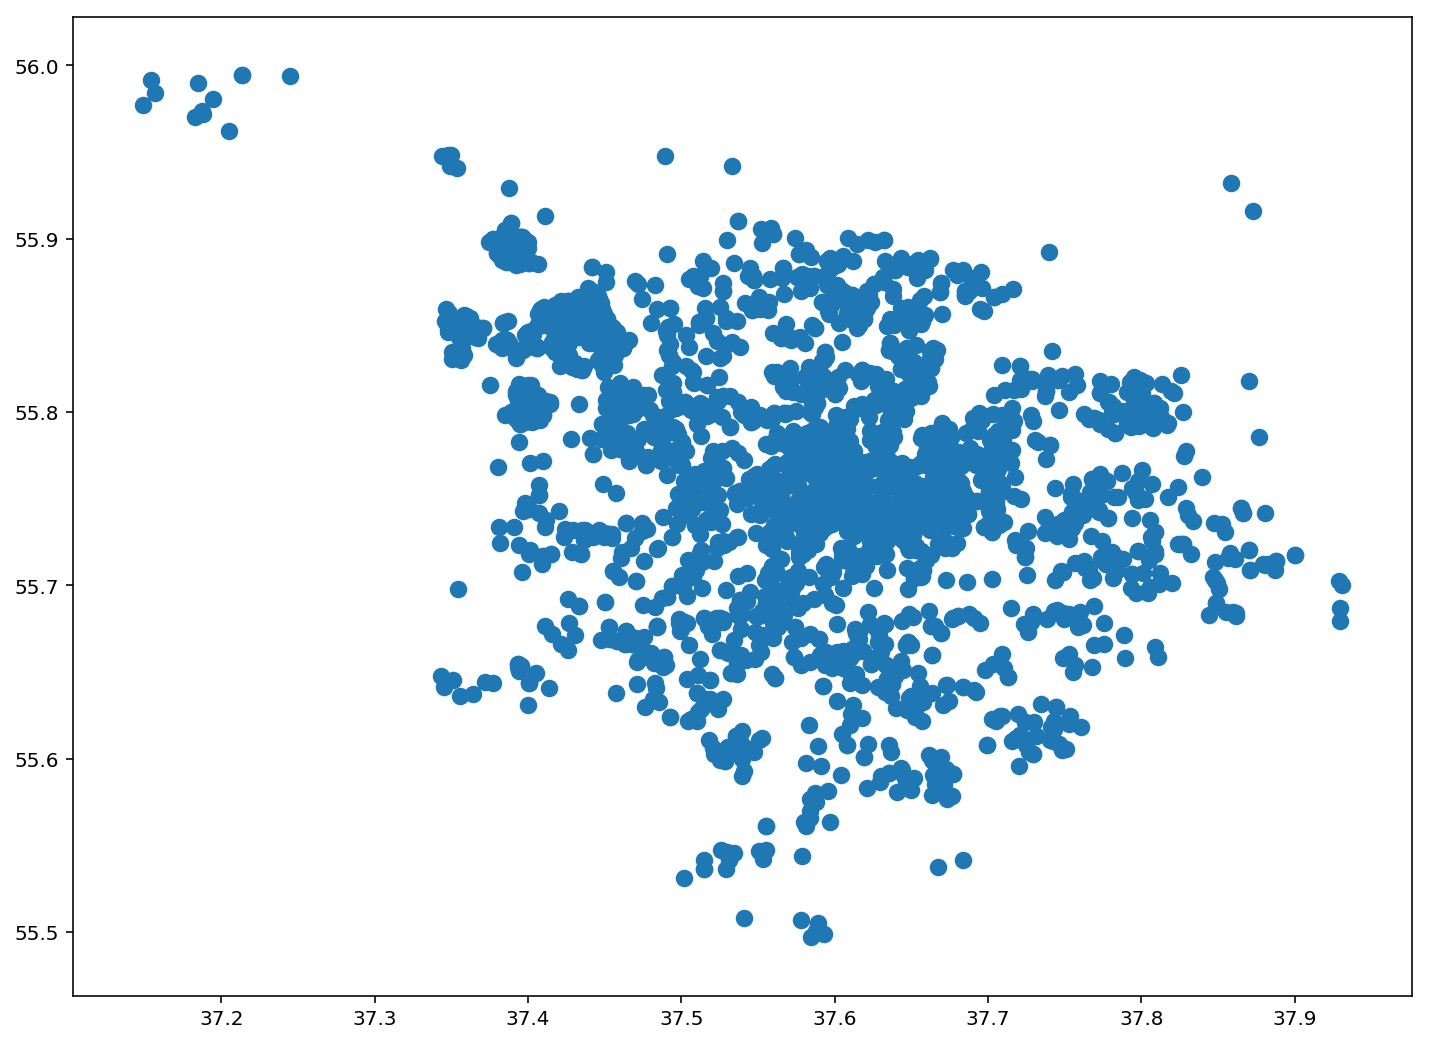

In [98]:
plt.scatter(v1.x, v1.y,  cmap='autumn', s=60)

отобразим результаты голосования (за и против)

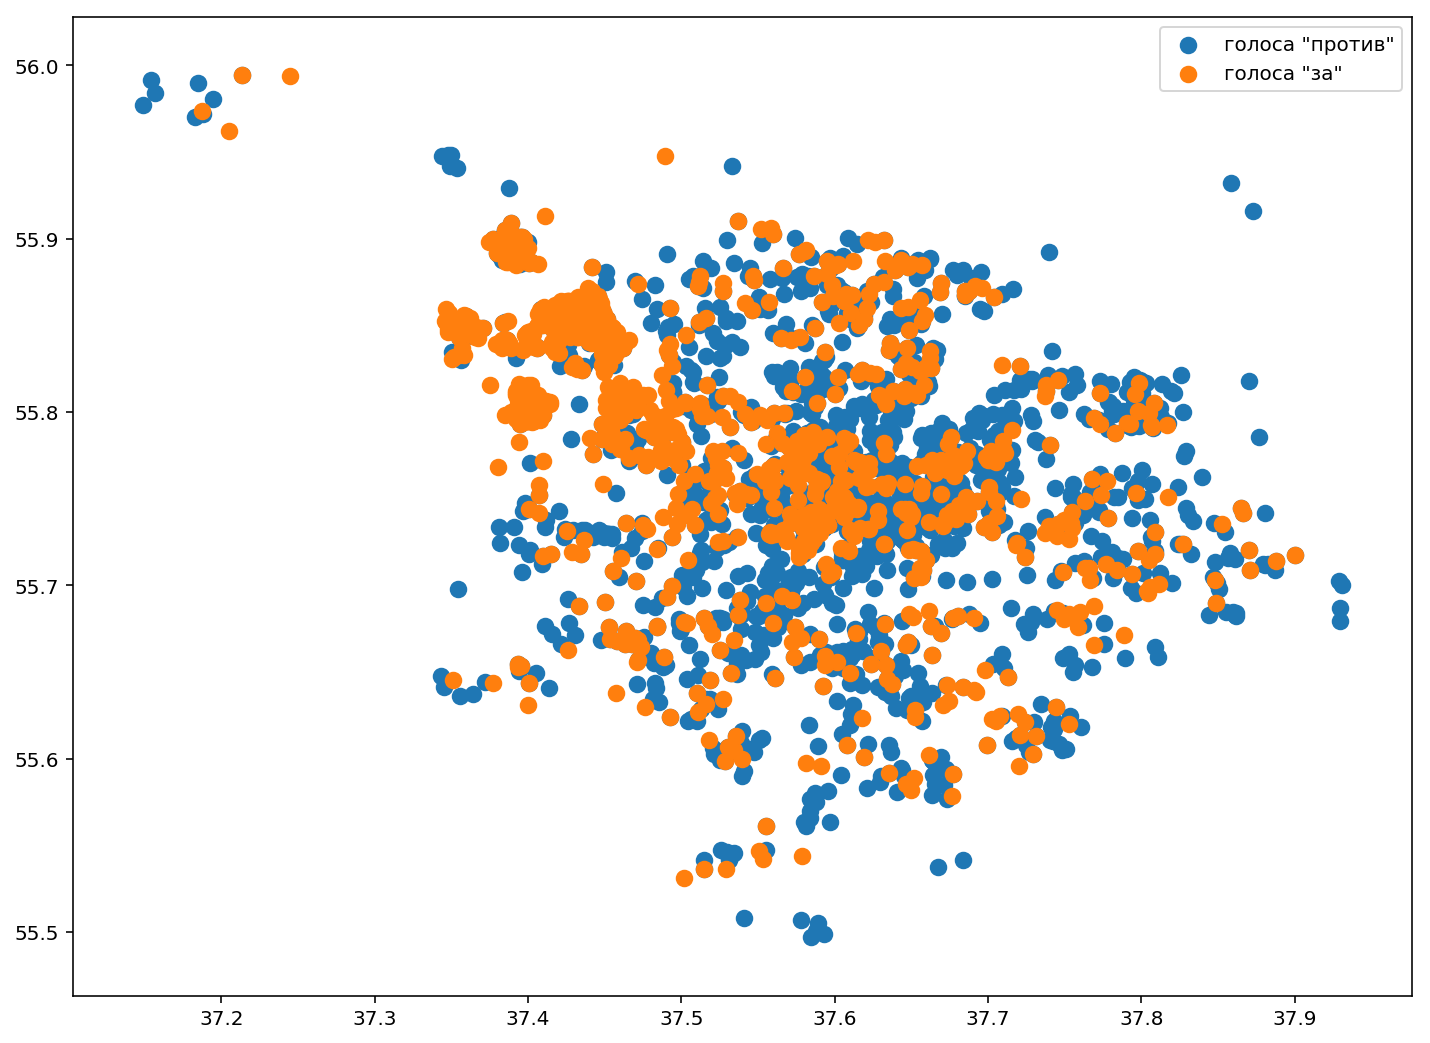

In [156]:
plt.scatter(v1[v1['comment_class']<0].x, v1[v1['comment_class']<0].y,  cmap='autumn', s=60, label='голоса "против"')
plt.scatter(v1[v1['comment_class']>0].x, v1[v1['comment_class']>0].y,  cmap='autumn', s=60, label='голоса "за"')
plt.legend()

приведём данные по обеим осям к нормальному распределению

In [12]:
from sklearn.preprocessing import StandardScaler

для общей выборки

In [104]:
X = v1[['x', 'y']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

для положительно проголосовавших

In [105]:
X_positive = v1[v1['comment_class']>0][['x', 'y']]
scaler_positive = StandardScaler()
X_positive_scaled = scaler_positive.fit_transform(X_positive)

для отрицательно проголосовавших

In [106]:
X_negative = v1[v1['comment_class']<0][['x', 'y']]
scaler_negative = StandardScaler()
X_negative_scaled = scaler_negative.fit_transform(X_negative)

In [16]:
from sklearn.cluster import KMeans

кластеризуем исходную выборку. Будем считать что количество кластеров равно количеству округов Москвы, т.е. 9+1 (Зеленоградский округ - судя по точкам на северо-западе, оттуда есть голоса)

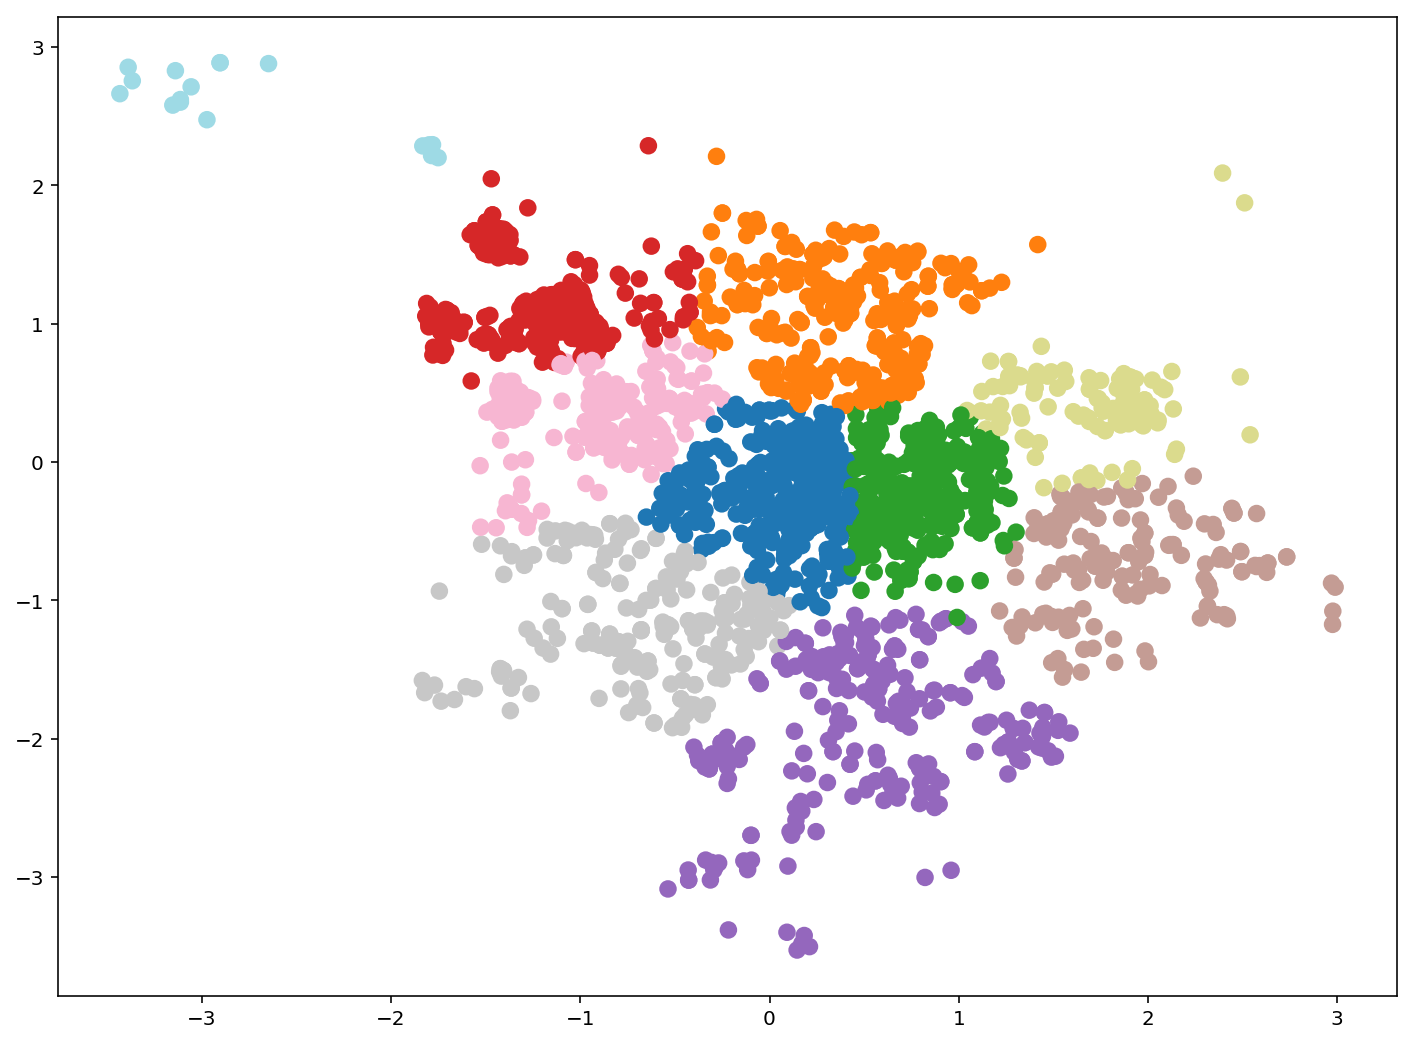

In [121]:
clusters = KMeans(n_clusters=10, random_state =22).fit_predict(X_scaled)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1],  c=clusters, cmap='tab20', s=60)


кластеризуем выборку для положительно проголосовавших

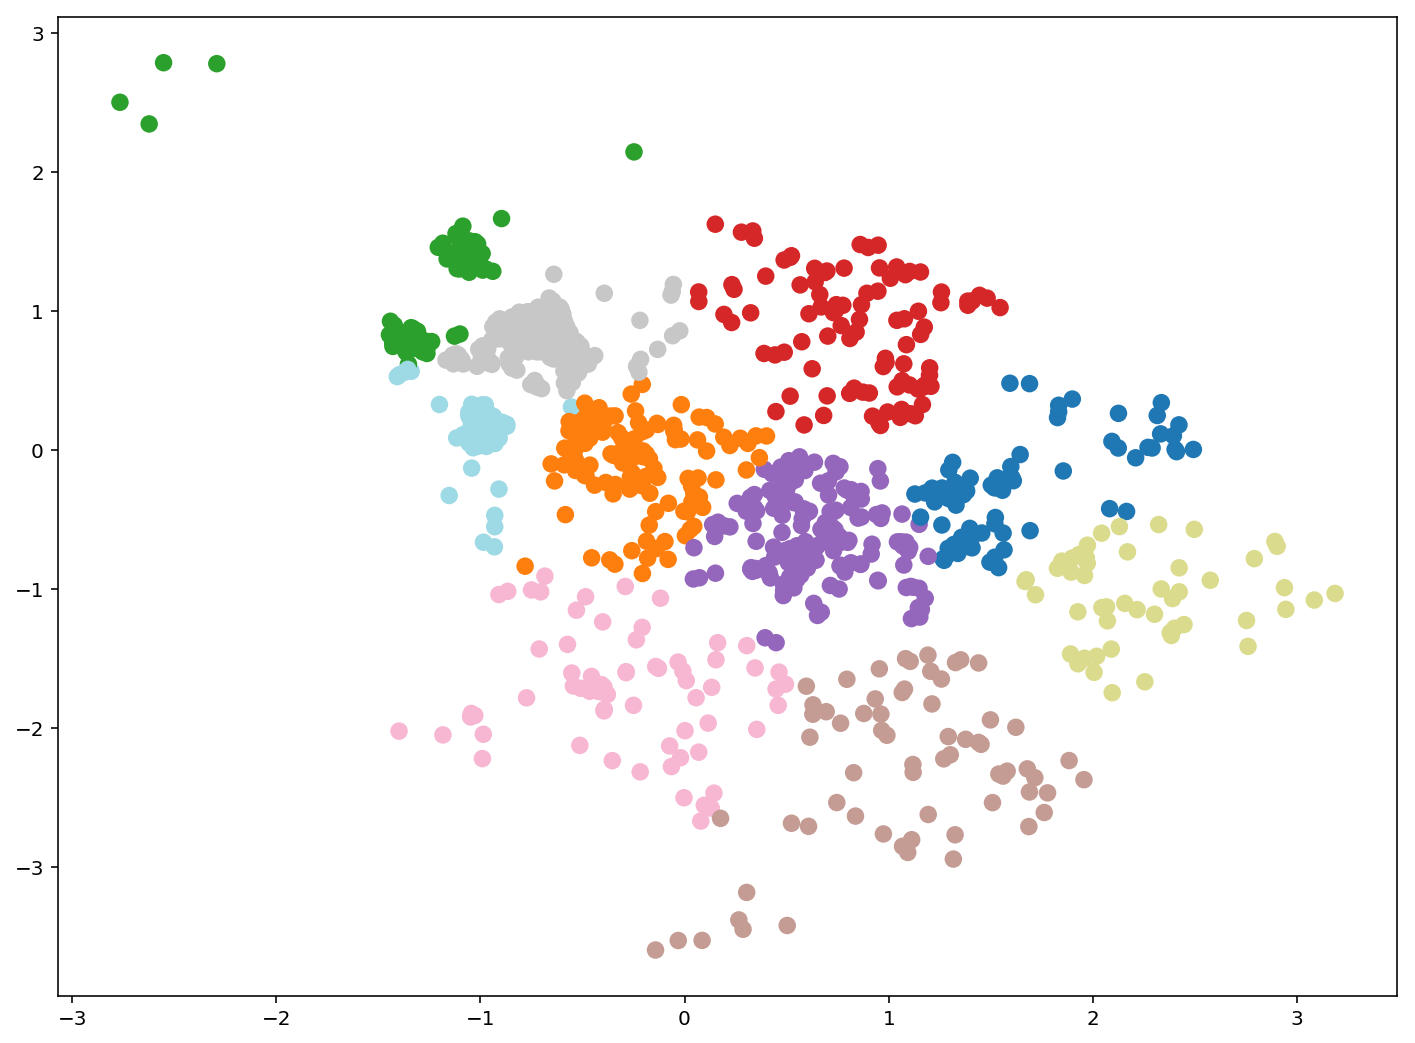

In [122]:
clusters_positive = KMeans(n_clusters=10, random_state =22).fit_predict(X_positive_scaled)
plt.scatter(X_positive_scaled[:, 0], X_positive_scaled[:, 1],  c=clusters_positive, cmap='tab20', s=60)


кластеризуем выборку для отрицательно проголосовавших

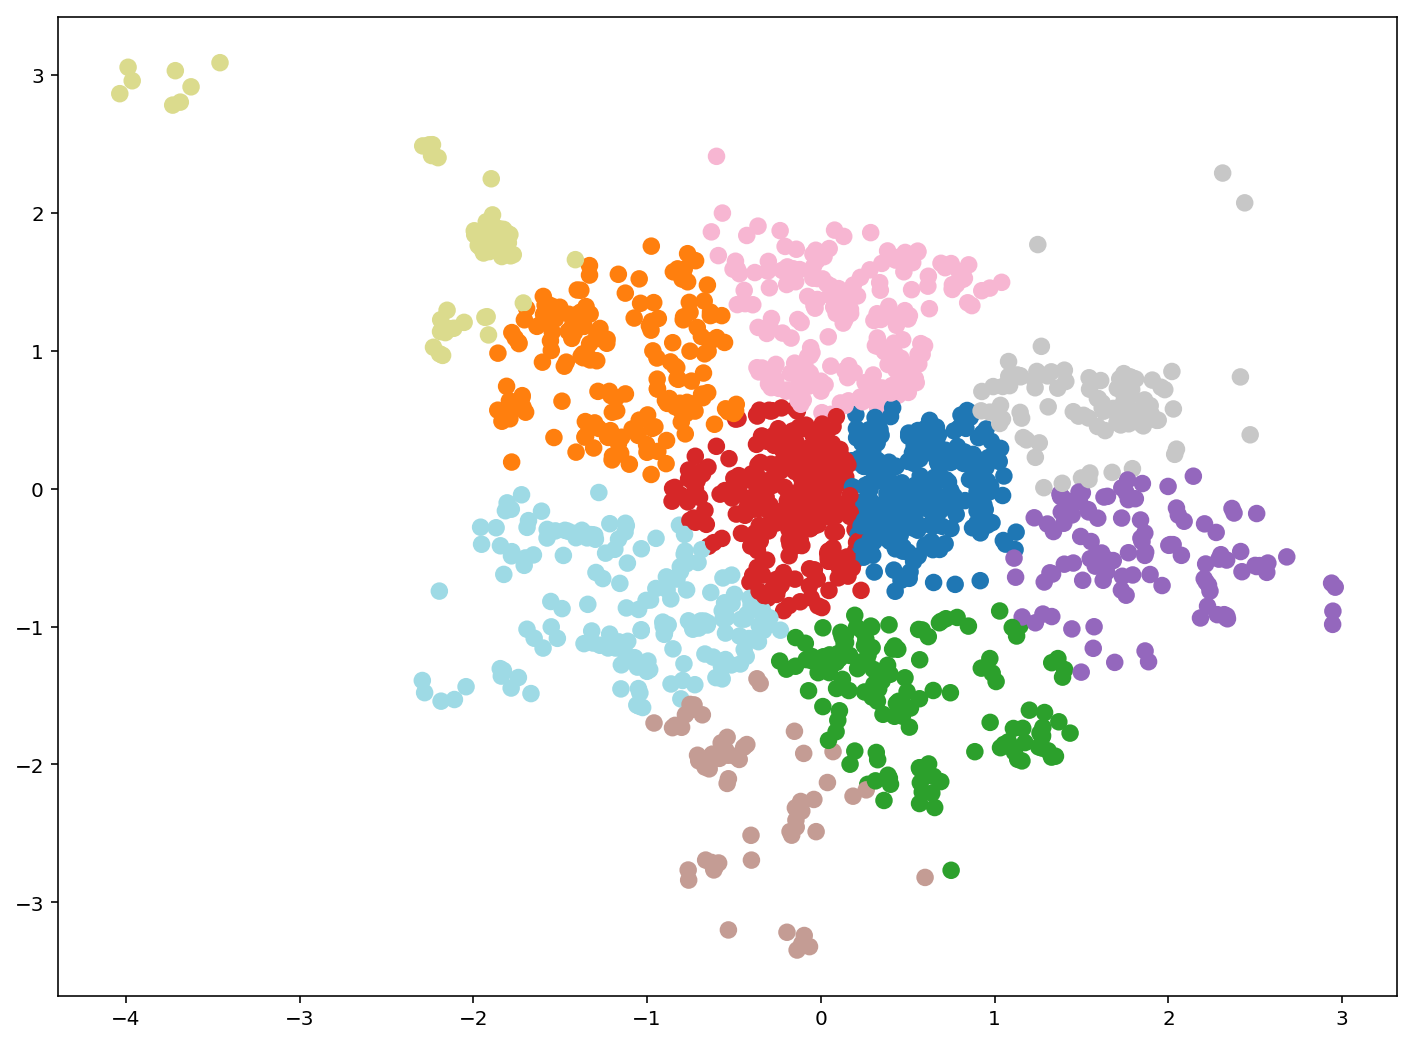

In [124]:
clusters_negative = KMeans(n_clusters=10, random_state =22).fit_predict(X_negative_scaled)
plt.scatter(X_negative_scaled[:, 0], X_negative_scaled[:, 1],  c=clusters_negative, cmap='tab20', s=60)


подберем оптимальное число кластеров для каждой выборки

In [130]:
def find_num_clausters(X_scalsed, max_clust=20):
    k_inertia = []
    ks = range(1,max_clust)
    for k in ks:
        clf_kmeans = KMeans(n_clusters=k)
        clusters_kmeans = clf_kmeans.fit_predict(X_scalsed, )
        k_inertia.append(clf_kmeans.inertia_)
        
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    plt.plot(ks[1:-1], diff_r)
    k_opt = ks[np.argmin(diff_r)+1]
    print('opt_clust=',k_opt)
    return k_opt

кластеризуем исходную выборку

opt_clust= 2


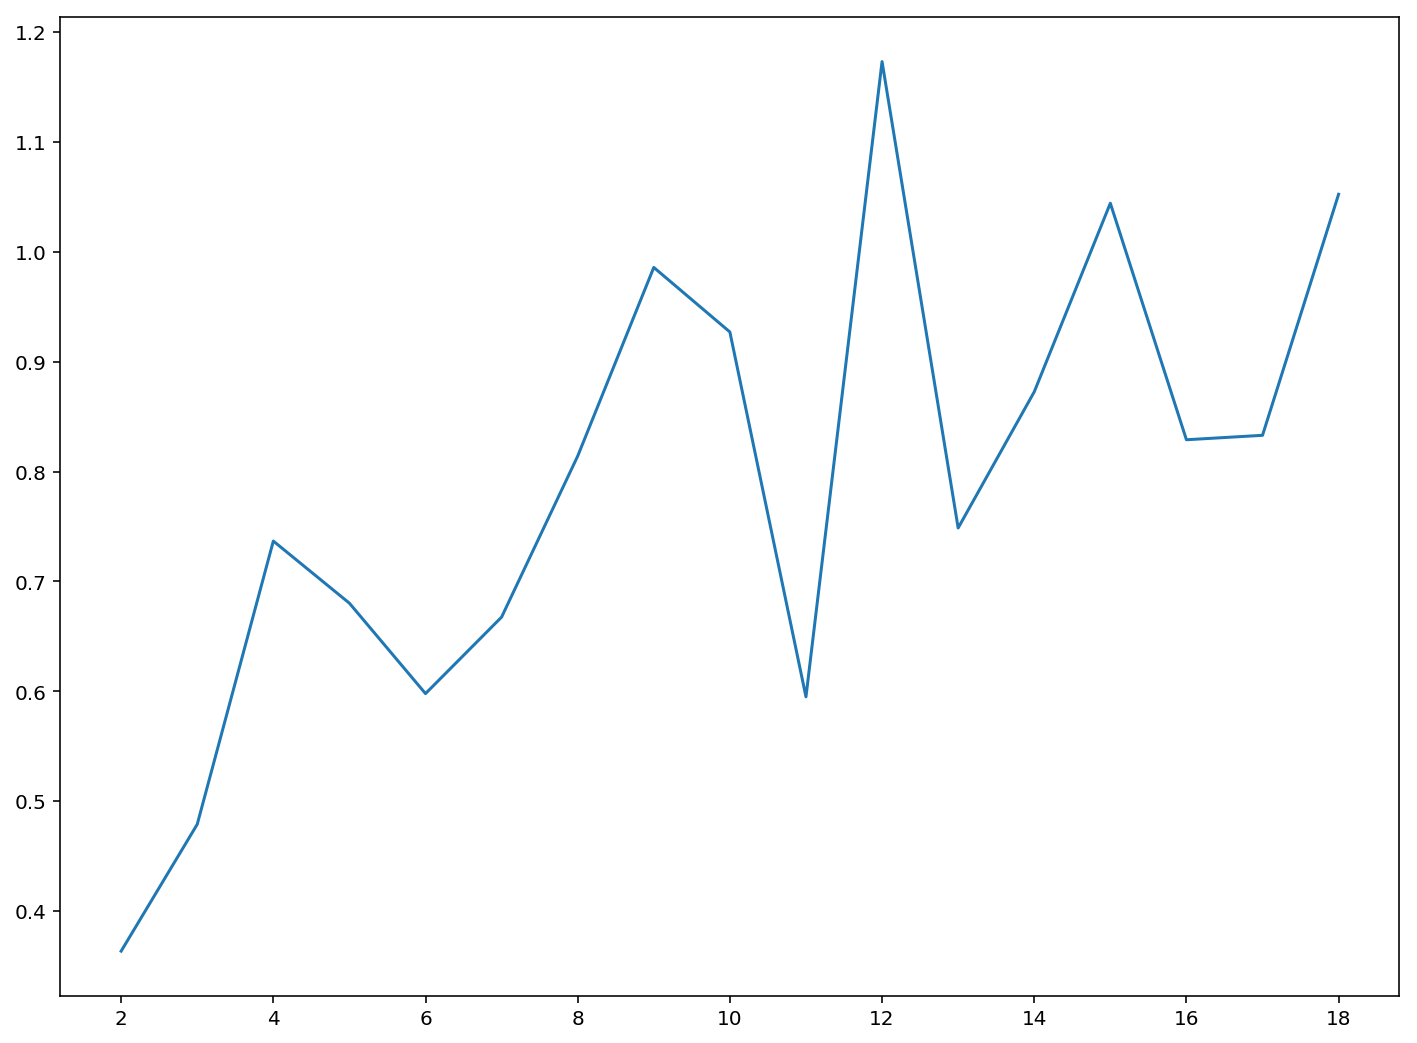

In [138]:
opt_num_clast = find_num_clausters(X_scaled)

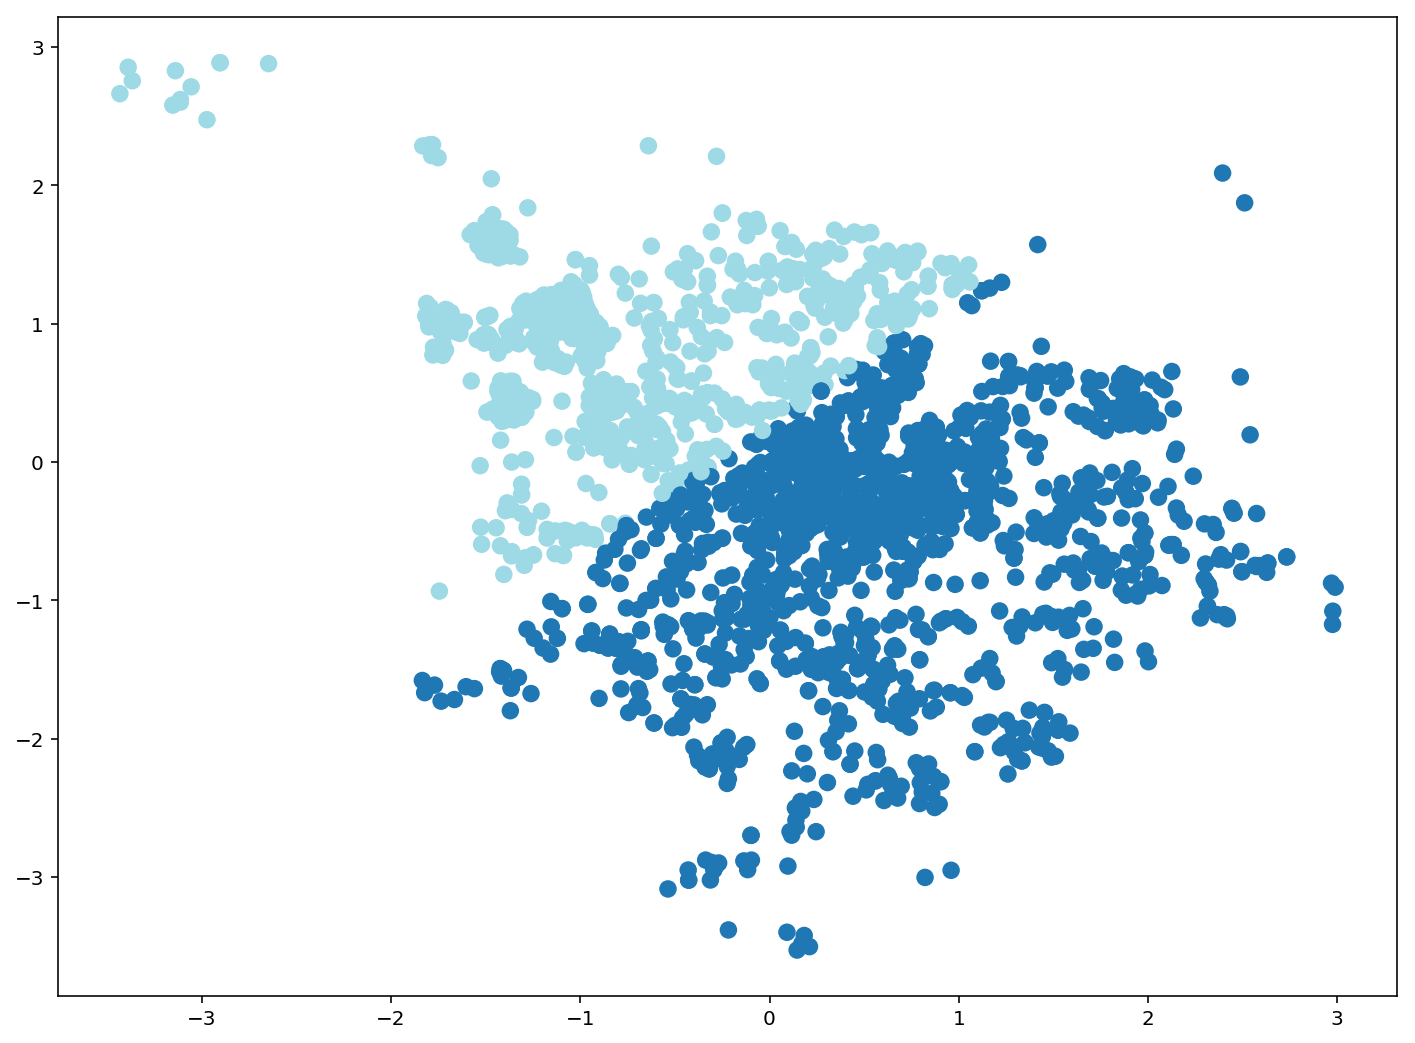

In [135]:
clusters = KMeans(n_clusters=opt_num_clast, random_state =22).fit_predict(X_scaled)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1],  c=clusters, cmap='tab20', s=60)

2 кластера для Москвы - это явно не тот результат, который ожидается. Поэтому выбирем следующий "минимум" - это 6 или 11 кластеров

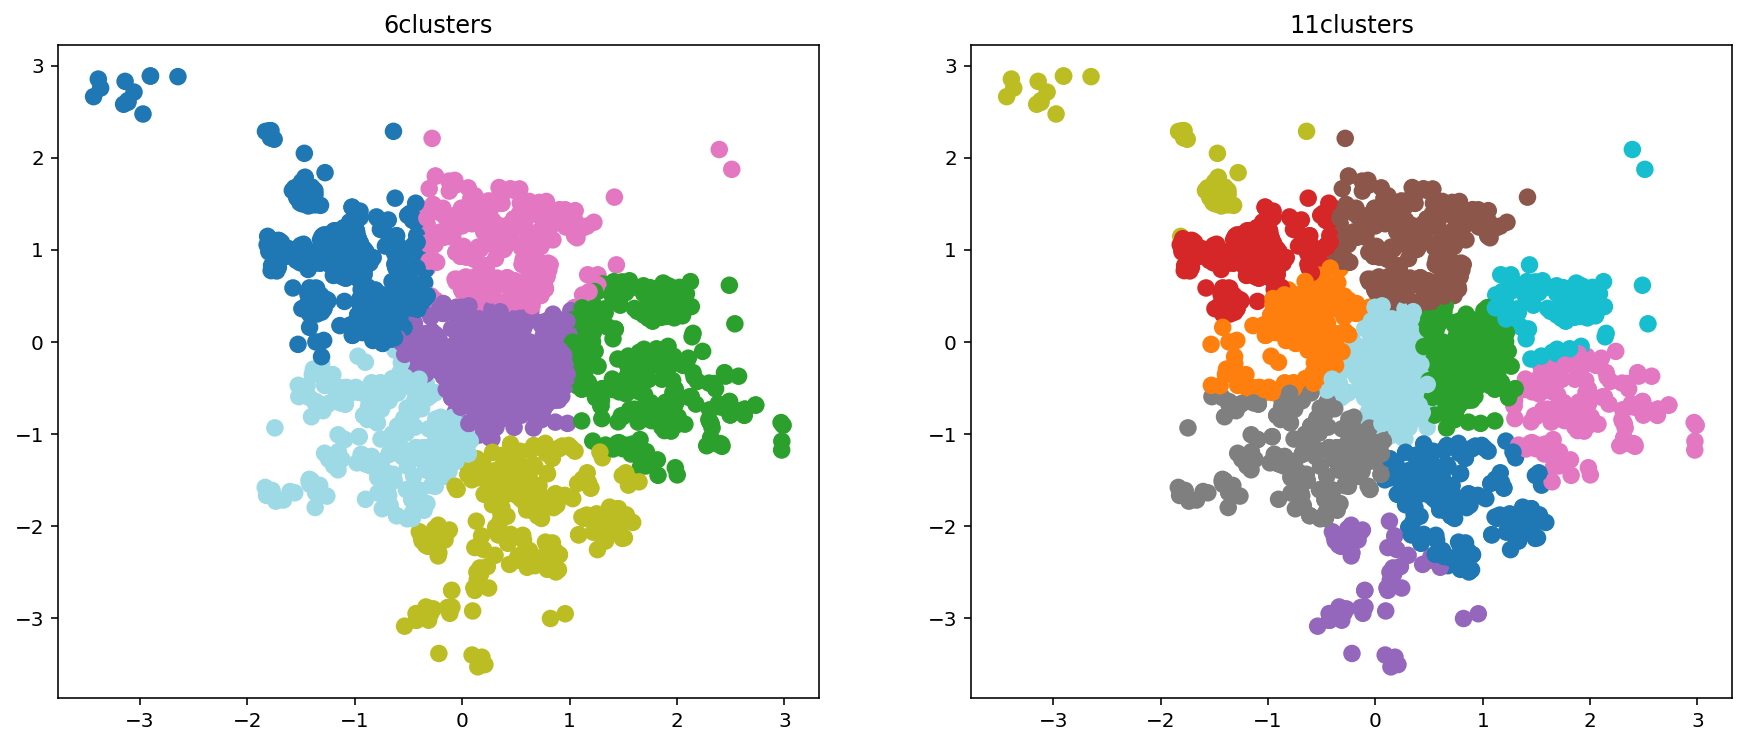

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
clus = [6, 11]
for ax, cl in zip(axes, clus):
    clusters = KMeans(n_clusters=cl, random_state =22).fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='tab20', s=60)
    ax.set_title(str(cl) + 'clusters')


такое же количество кластеров, но с использованием иерархической кластеризации

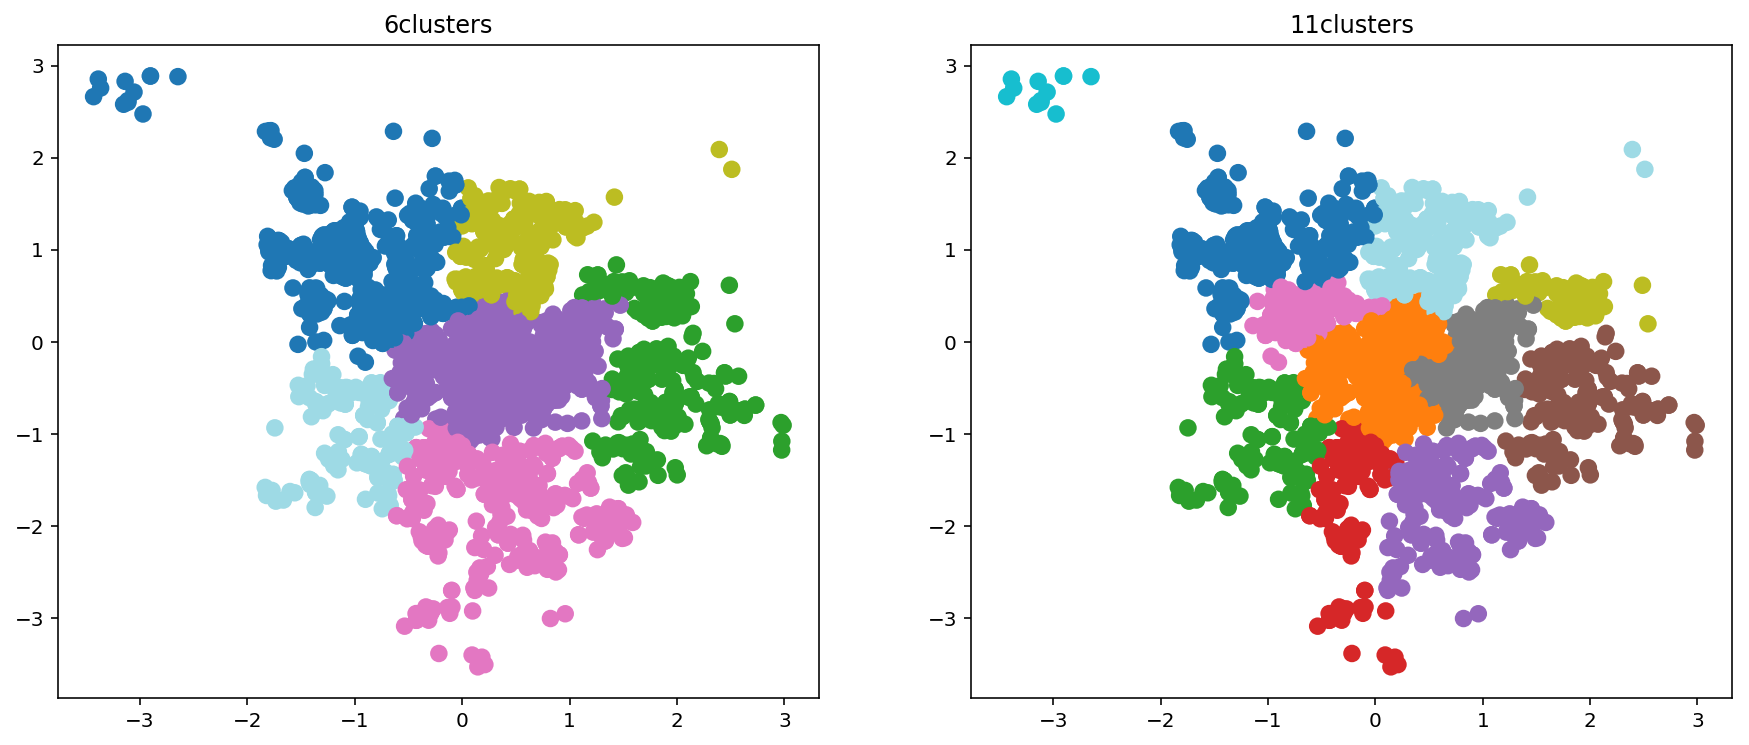

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
clus = [6, 11]
for ax, cl in zip(axes, clus):
    clusters = AgglomerativeClustering(n_clusters=cl).fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='tab20', s=60)
    ax.set_title(str(cl) + 'clusters')


opt_clust= 2


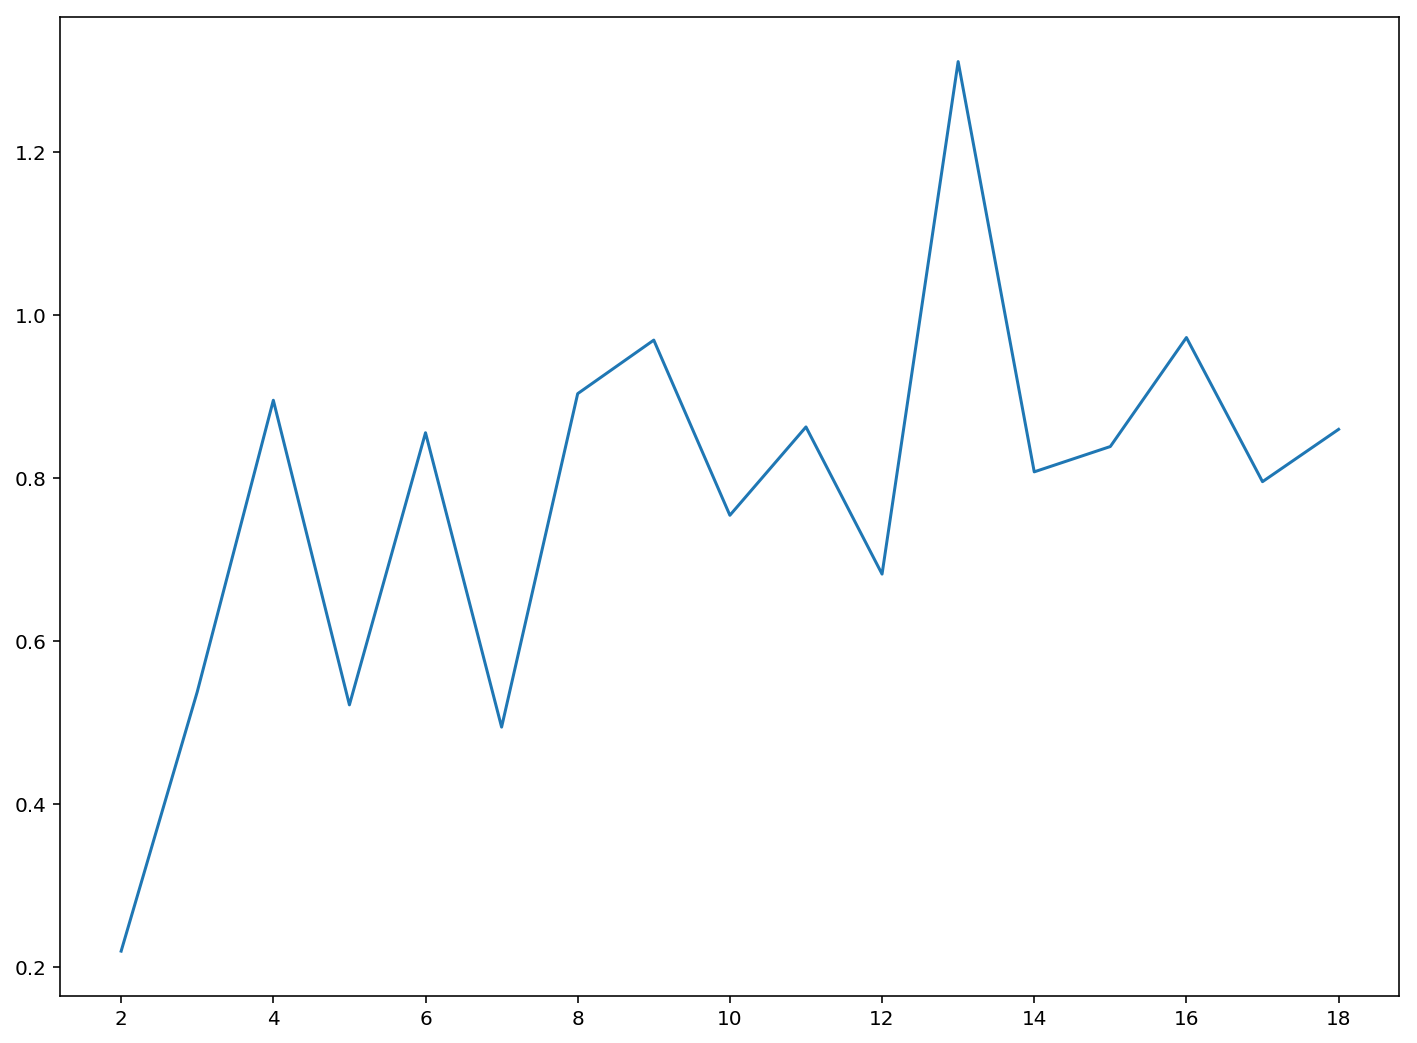

In [146]:
opt_num_clast_positive = find_num_clausters(X_positive_scaled)

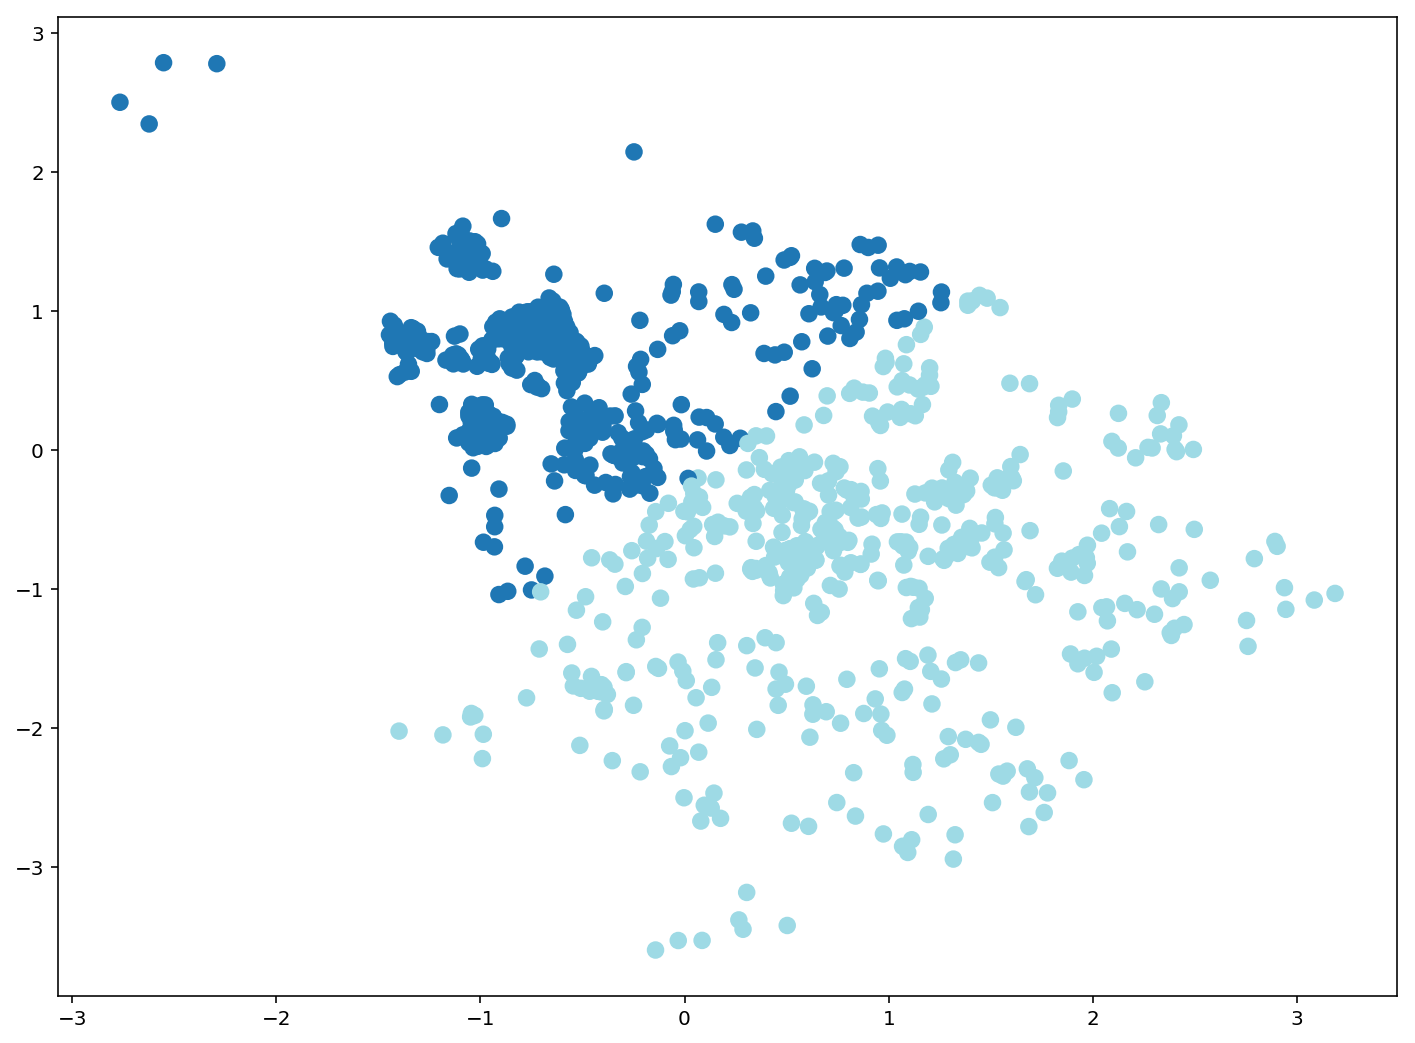

In [147]:
clusters_positive = KMeans(n_clusters=opt_num_clast_positive).fit_predict(X_positive_scaled)
plt.scatter(X_positive_scaled[:, 0], X_positive_scaled[:, 1],  c=clusters_positive, cmap='tab20', s=60)


2 кластера - это опять маловато. Поэтому выбирем следующий "минимум" - это 5 или 7 кластеров

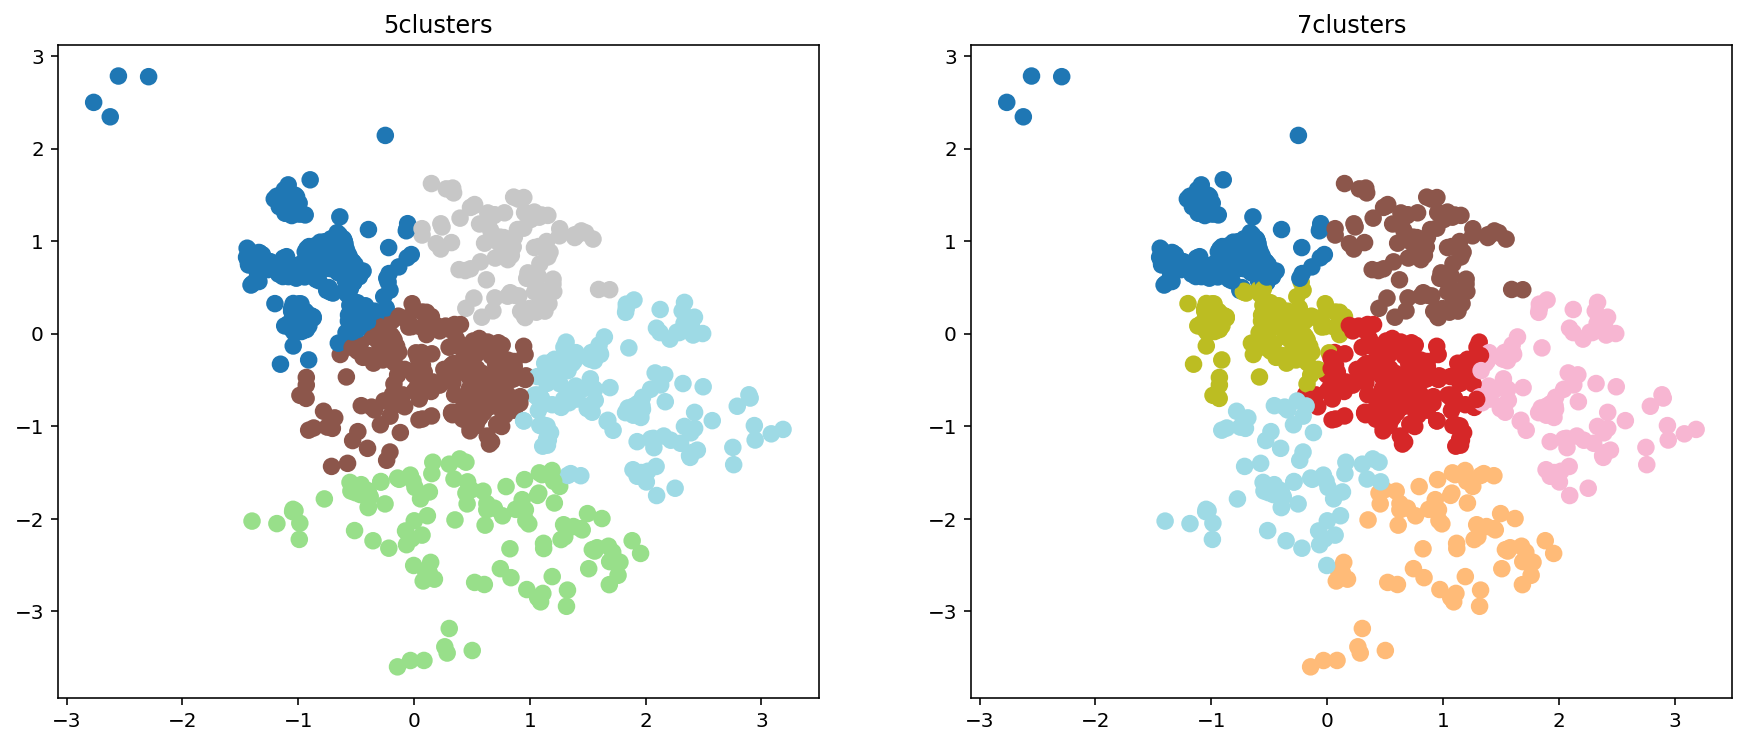

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
clus = [5, 7]
for ax, cl in zip(axes, clus):
    clusters_positive = KMeans(n_clusters=cl, random_state =22).fit_predict(X_positive_scaled)
    ax.scatter(X_positive_scaled[:, 0], X_positive_scaled[:, 1], c=clusters_positive, cmap='tab20', s=60)
    ax.set_title(str(cl) + 'clusters')


такое же количество кластеров, но с использованием иерархической кластеризации

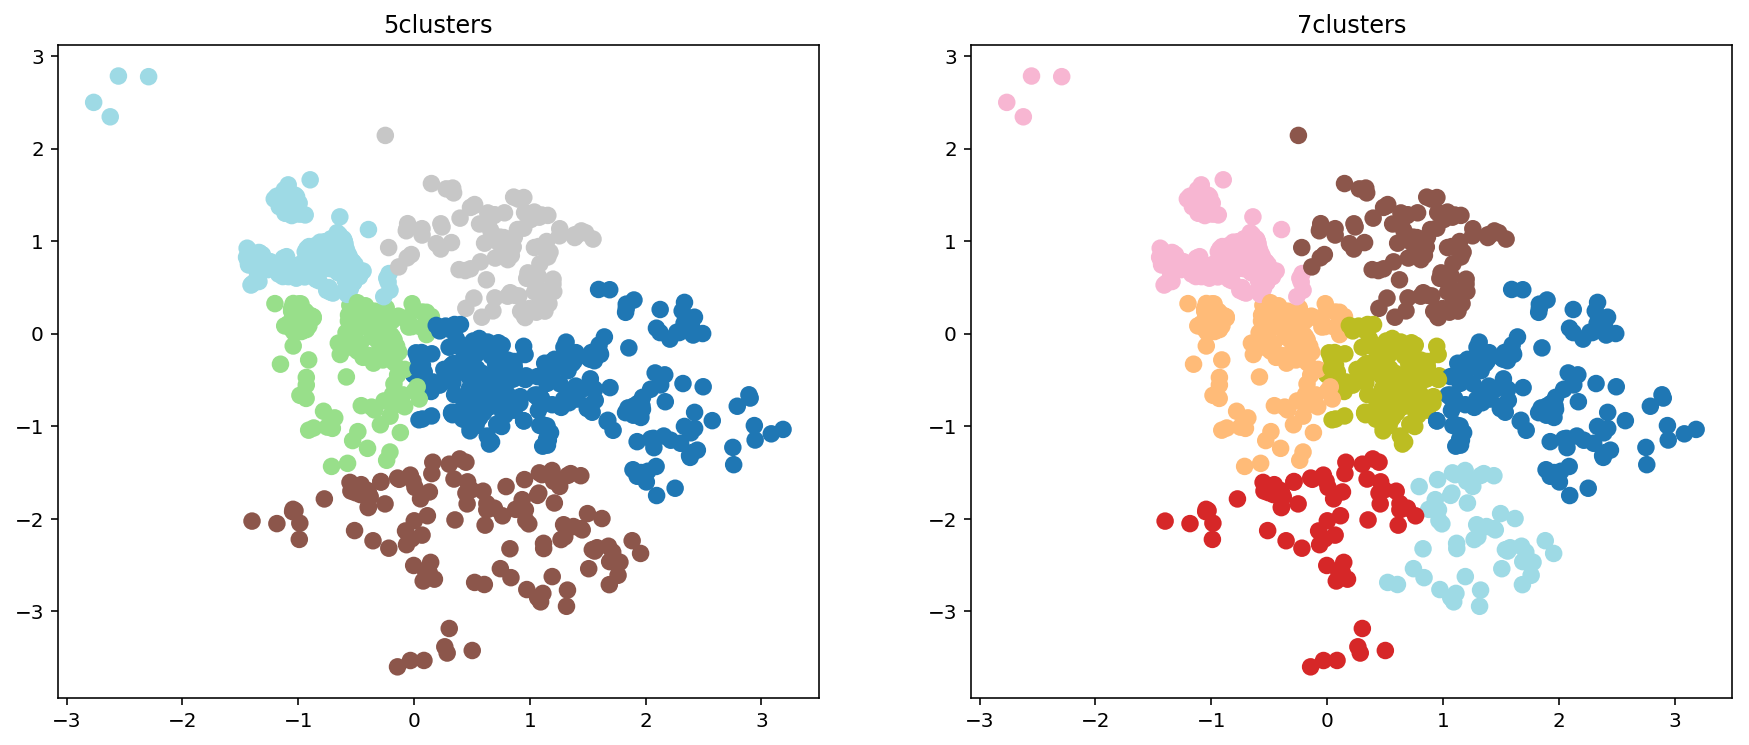

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
clus = [5, 7]
for ax, cl in zip(axes, clus):
    clusters_positive = AgglomerativeClustering(n_clusters=cl).fit_predict(X_positive_scaled)
    ax.scatter(X_positive_scaled[:, 0], X_positive_scaled[:, 1], c=clusters_positive, cmap='tab20', s=60)
    ax.set_title(str(cl) + 'clusters')


opt_clust= 6


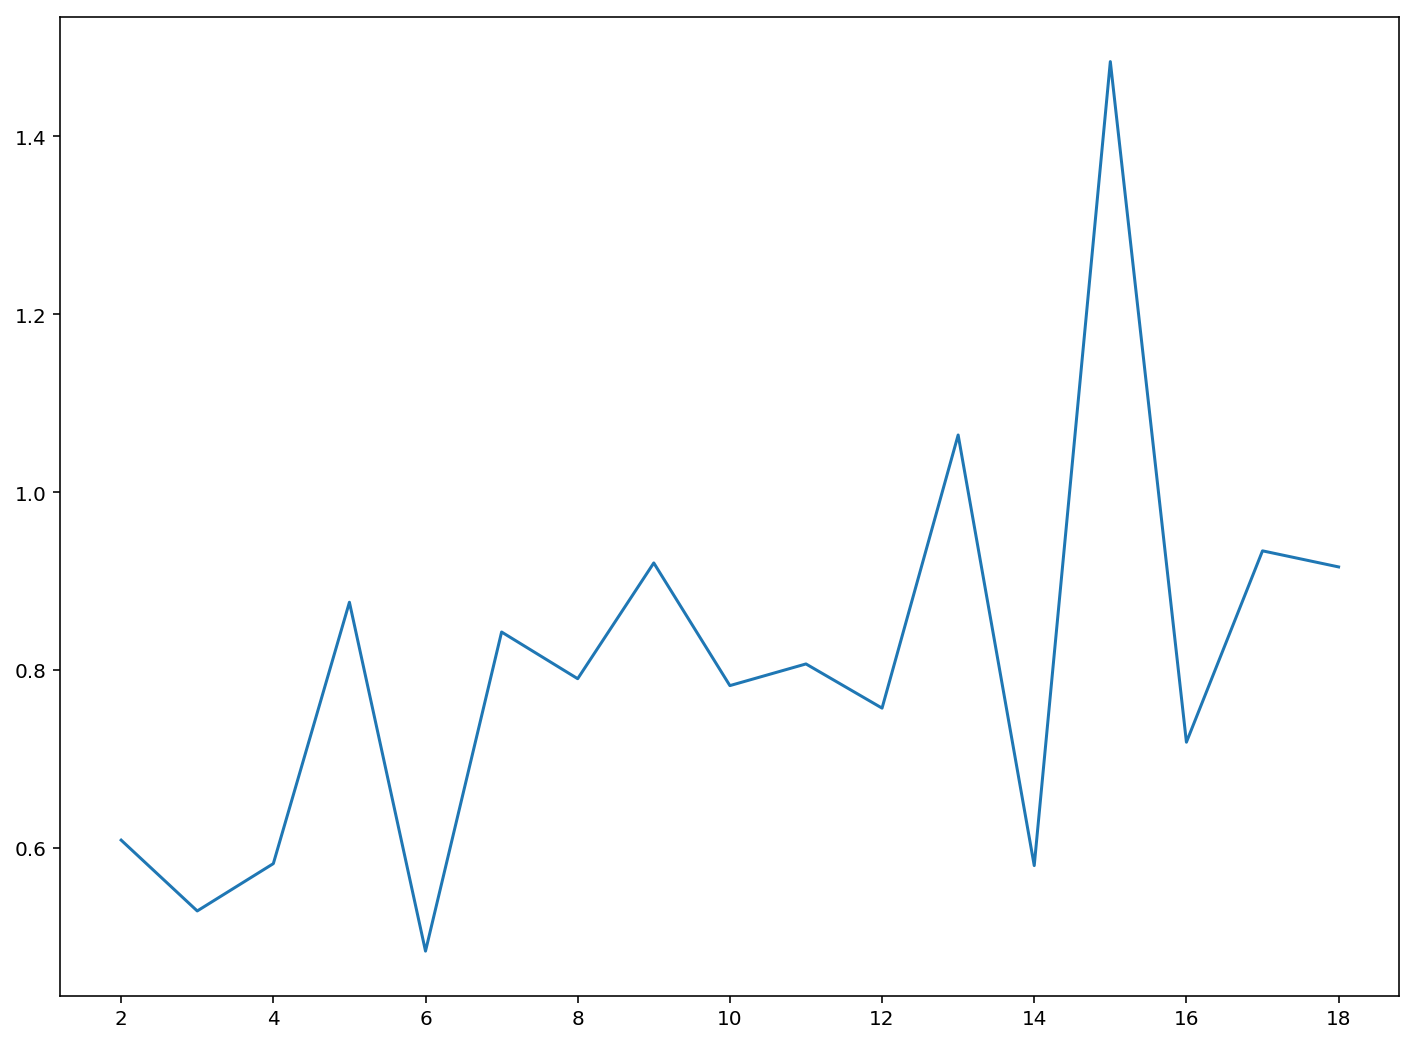

In [151]:
opt_num_clast_negative = find_num_clausters(X_negative_scaled)

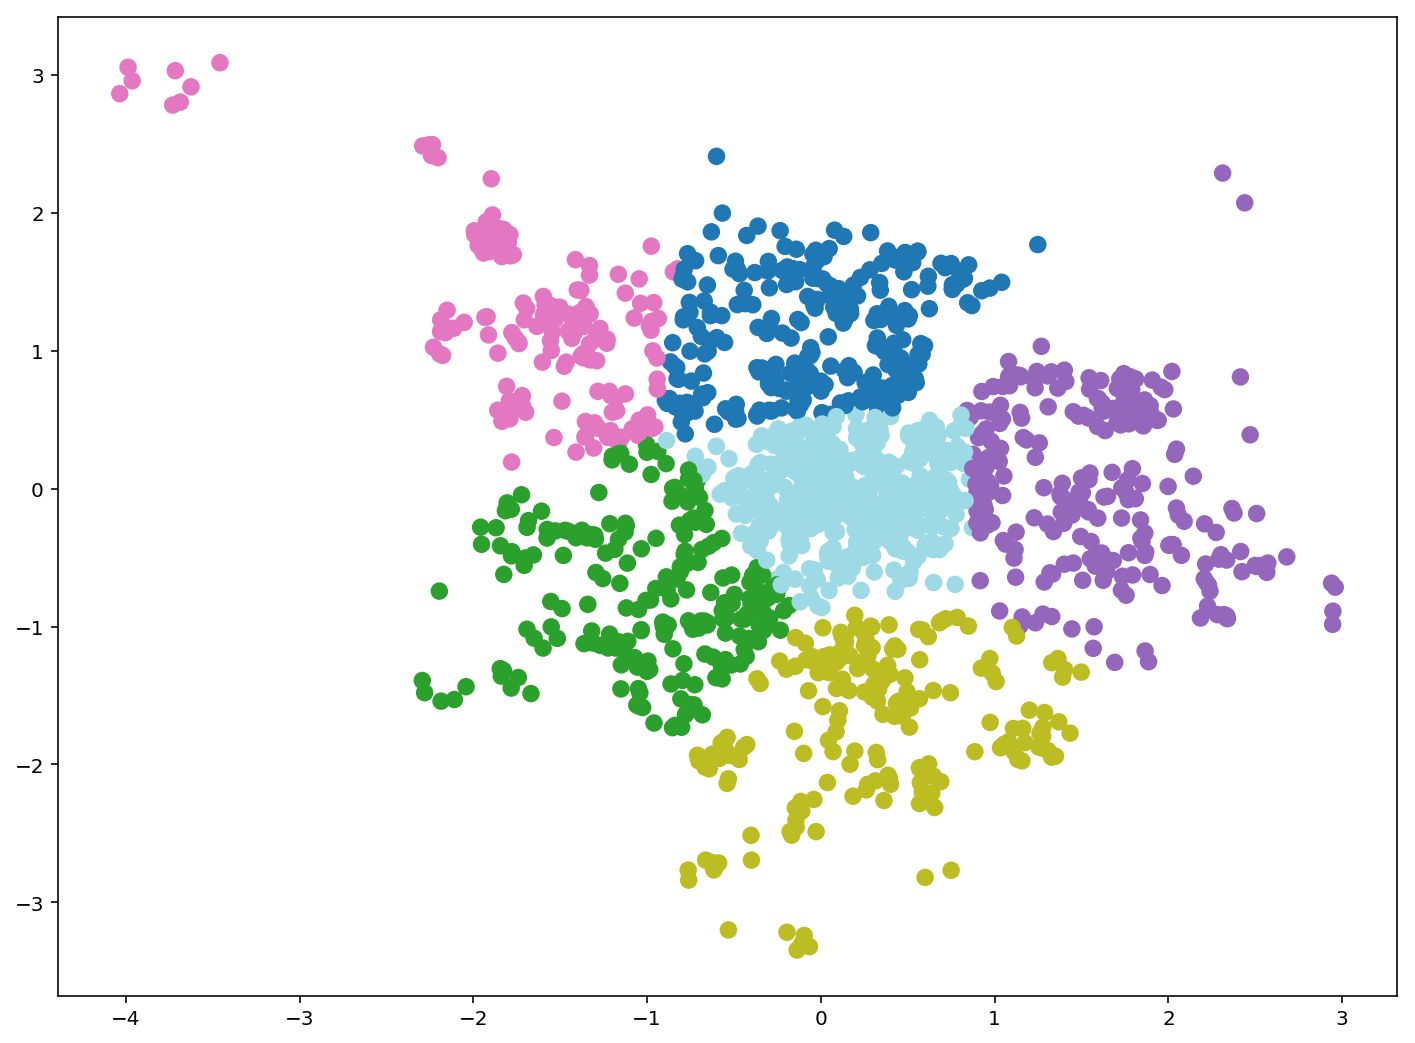

In [153]:
clusters_positive = KMeans(n_clusters=opt_num_clast_negative).fit_predict(X_negative_scaled)
plt.scatter(X_negative_scaled[:, 0], X_negative_scaled[:, 1],  c=clusters_negative, cmap='tab20', s=60)


такое же количество кластеров, но с использованием иерархической кластеризации

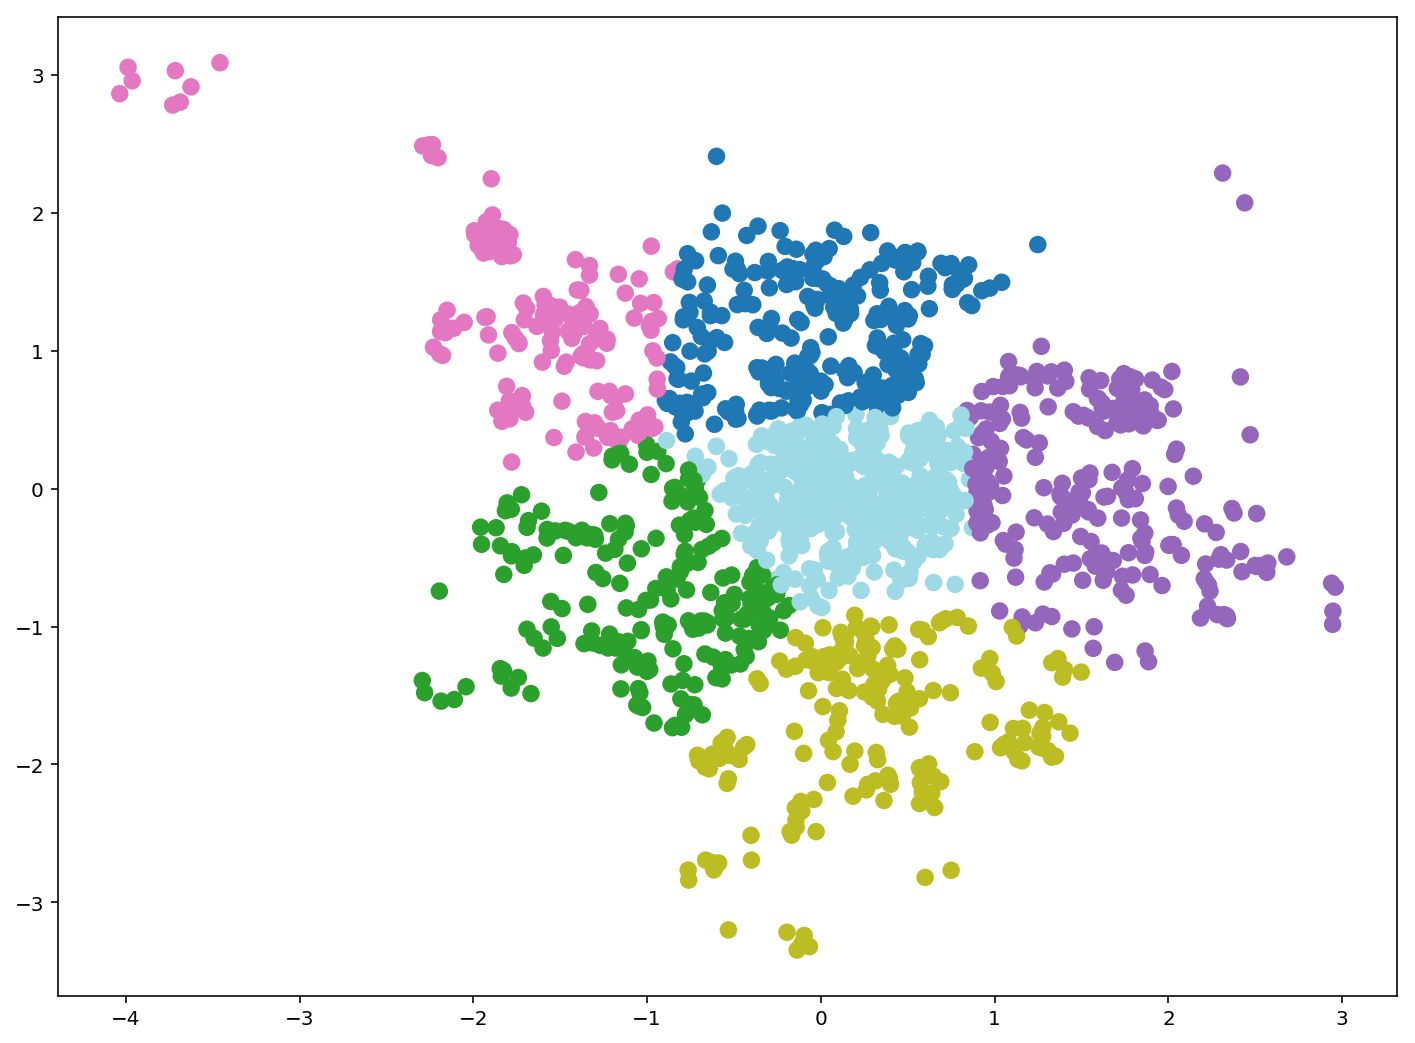

In [165]:
clusters_positive = AgglomerativeClustering(n_clusters=6).fit_predict(X_negative_scaled)
plt.scatter(X_negative_scaled[:, 0], X_negative_scaled[:, 1],  c=clusters_negative, cmap='tab20', s=60)


в данном случае, полученный стохастически результат (6 кластеров) - вполне удовлетворительный